# CS 6140 Machine Learning: Assignment - 3 (Total Points: 100)
## Prof. Ahmad Uzair 

### Q1. Implementing Decision Tree from Scratch (60 points)

You will implement the decision tree algorithm for the mushroom dataset. The dataset is provided to you with this assignment (mushroom.csv).
The objective is to classify whether a mushroom is poisonous or edible based on various features.
You will write a program that uses some algorithm to construct a decision tree, and use the tree to classify new instances.
Your implementation should include the following functions:
1. EDA on dataset
2. Calculate the entropy of a dataset
3. Split a dataset based on an attribute and its value  
4. Select the attribute to split the dataset on
5. Build a decision tree
6. Classify an instance using the decision tree
7. Calculate testing accuracy.


 Note : Perform EDA at steps like splitting data etc.



# EDA on dataset

In [1]:
import logging
import pandas as pd
import seaborn as sb
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

In [2]:
def stack_bar_break_out_by_edibility(dataframe, attribute: str):
    """
    Drawing a stack bar breakout by editibility. This would help us analyze what 
    """
    try:
        if attribute == 'class':
            sb.set(font_scale=1.4)
            dataframe[f'{attribute}'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0, color=['blue', 'red']);
            plt.title("Count of Poisonsous vs Edible mushrooms", y=1.02);
        else:
            dataframe.groupby([f'{attribute}', 'class']).size().unstack().plot(kind='bar', 
                                                                               stacked=True, 
                                                                               figsize=(7, 6), 
                                                                               rot=0, 
                                                                               color=['blue', 'red'])
            plt.title(f'Count {str(attribute).upper()} break out by Edibility');
        plt.show()
    except Exception as err:
        logging.error(f'Fail with error: {err}', exc_info = True)
        raise err


def read_csv():
    """
    Read mushrooms.csv
    """
    read_file = pd.read_csv(r'C:\Users\Leaksmy Heng\Documents\GitHub\cs6140\HW3\mushrooms.csv')
    return read_file
    

def conduct_eda():
    """
    Read csv and conduct the exploratory data analysis.
    @param file_path: file path that we want to read
    @type file_path: string
    @return read_file
    @rtype: dataframe
    """
    read_file = read_csv()
    
    # understand the shape of our data
    shape_of_data = read_file.shape
    total_number_of_rows = shape_of_data[0]
    total_number_of_columns = shape_of_data[1]
    print(shape_of_data)
    
    # understand the data, and its metrics
    describe_data = read_file.describe().T
    print(describe_data)
    
    # understand the data type
    datatype = read_file.info()
    print(datatype)
    
    # display a frew row
    sample = read_file.head()
    print(sample)
    
    # examine count of labelling data and build a stack graph
    list_of_columns = read_file.columns
    for row in list_of_columns:
        stack_bar_break_out_by_edibility(read_file, row)
    
    # based on the stack bar, there are only 1 veil-type. And the veil type is both edible and poison
    # hence we could drop that
    read_file = read_file.drop('veil-type', axis = 1)
    
    # new data frame after dropping
    df = read_file.columns
    
    # encode the column
    encoder = LabelEncoder()
    for column in df:
        read_file[column] = encoder.fit_transform(read_file[column])
    
    # check if there are any null value
    null_val = read_file.isnull().sum()
    print(null_val)
    
    # checking correlation now that our data is encoded
    corr = read_file.corr()
    sb.heatmap(corr, square=True)
    
    return read_file
    

# Build a decision tree to include:

In [3]:
class DecisionTree:
    """
    Creating a decision tree using entropy.
    """
    def __init__(self, max_depth=None, min_samples_split=2, min_impurity=1e-7):
        """
        Create a constructor for Decision Tree using CART classification and regression trees.
        @param max_depth: max depthh hyperparameter that is used to stop the recursive when splitting data
        @param min_samples_split: another hyperparameter that is used to stop the recursive when splitting data
        @param min_impurity: another hyperparameter that is used to stop the recursive when splitting data, 
        default value of 0.0000001
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        self.tree = {}
    
    
    def split_data(self, x_training, feature, threshold):
        """
        Splitting the training set into 2 subsets using a feature and a threshold.
        This will be used recursively to split the sub-subsets.
        @param x_training: training data set
        @param feature: feature
        @param threshold: threshold. Example is the mushroom eatable?
        """
        left = np.where(x_training[:, feature] <= threshold)
        right = np.where(x_training[:, feature] > threshold)
        
        return left[0], right[0]
    
        
    def entropy(self, y):
        """
        calculating the entropy of the labeling data.
        @param y: labeling data 
        """
        label, each_label_counts = np.unique(y, return_counts=True)
        probability = each_label_counts / np.sum(each_label_counts)
        entropy = -np.sum(probability * np.log2(probability))
        
        return entropy

        
    def information_gain(self, y, left_y, right_y):
        """
        calculating information gain.
        @param y: labeling data
        @param left_y: labeling data on the left child node after splitting
        @param right_y: labeling data on the right child node after splitting
        """
        left_probability = len(left_y) / len(y)
        right_probability = len(right_y) / len(y)
        entropy_parent = self.entropy(y)
        entropy_left = self.entropy(left_y)
        entropy_right = self.entropy(right_y)
        information_gain = entropy_parent - left_probability*entropy_left - right_probability*entropy_right
        
        return information_gain
        
        
    def select_attribute(self, x_training, y_training):
        """
        Selecting the pair with best feature & best threshold (k, tk) that produce the purest subsets.
        To select the pair, we need to use an information_gain to check.
        @param x_training: training data set
        @param y_training: label training data set
        """
        best_feature = None
        best_threshold = None
        max_info_gain = -np.inf
        features = x_training.shape[1]
        
        # check each feature to find the best one with its threshold
        for feature in range(features):
            each_feature = x_training[:, feature]
            thresholds = np.unique(each_feature)
            
            for threshold in thresholds:
                left_node, right_node = self.split_data(x_training, feature, threshold)
                if len(left_node) == 0 or len(right_node) == 0:
                    continue
                
                # calculating information gain
                info_gain = self.information_gain(y_training, y_training[left_node], y_training[right_node])
                if info_gain > max_info_gain:
                    best_feature = feature
                    best_threshold = threshold
                    max_info_gain = info_gain
        
        if max_info_gain < self.min_impurity:
            best_feature = None
            best_threshold = None
        
        return best_feature, best_threshold
        
        
    def majority_class(self, y):
        """
        Determine the majority class in a given set of labels.
        @param y_training: label training data set
        """
        counter = Counter(y)
        majority_class = counter.most_common(1)[0][0]
        return majority_class
        
        
    def fit(self, x_training, y_training, depth = 0):
        """
        Training the dataset.
        @param x_training: training data set that exclude the labeling data
        @param y_training: labeling training data set
        """
        training_data, training_features = x_training.shape
        classes = len(np.unique(y_training))
        
        # stop training the data if the depth of the tree is equal to the maximum depth
        # or if the training data set is less than the sample data for splitting
        # or if the number of classes (edible vs poisonous) is == 1
        if (depth == self.max_depth) or (training_data < self.min_samples_split) or (classes == 1):
            self.tree = self.majority_class(y_training)
            return self.tree
        
        best_feature, best_threshold = self.select_attribute(x_training, y_training)
        if best_feature is None or best_threshold is None:
            self.tree = self.majority_class(y_training)
            return self.tree
        
        # recursively splitting the training data and increment the depth of the tree by 1
        left_tree, right_tree = self.split_data(x_training, best_feature, best_threshold)
        left_node = self.fit(x_training[left_tree], y_training[left_tree], depth + 1)
        right_node = self.fit(x_training[right_tree], y_training[right_tree], depth + 1)
        
        # store the tree in the dictionary
        self.tree = {'feature': best_feature,
                     'threshold': best_threshold,
                     'left_node': left_node,
                     'right_node': right_node
                    }
        
        return self.tree
        
        
    def traverse_tree(self, sample):
        """
        Traversing the tree.
        @sample: sample data set
        """
        node = self.tree
        while isinstance(node, dict):
            if sample[node['feature']] <= node['threshold']:
                node = node['left_node']
            else:
                node = node['right_node']
        return node
    
    
    def predict(self, x_testing):
        """
        Predicting algorithm. This algorithm requires traversing the tree from root to leave.
        @param x_testing: testing data set that you use to predict
        """
        y_pred = np.zeros(x_testing.shape[0])
        for i, tree in enumerate(x_testing):
            y_pred[i] = self.traverse_tree(tree)
        
        return y_pred

(8124, 23)
                         count unique top  freq
class                     8124      2   e  4208
cap-shape                 8124      6   x  3656
cap-surface               8124      4   y  3244
cap-color                 8124     10   n  2284
bruises                   8124      2   f  4748
odor                      8124      9   n  3528
gill-attachment           8124      2   f  7914
gill-spacing              8124      2   c  6812
gill-size                 8124      2   b  5612
gill-color                8124     12   b  1728
stalk-shape               8124      2   t  4608
stalk-root                8124      5   b  3776
stalk-surface-above-ring  8124      4   s  5176
stalk-surface-below-ring  8124      4   s  4936
stalk-color-above-ring    8124      9   w  4464
stalk-color-below-ring    8124      9   w  4384
veil-type                 8124      1   p  8124
veil-color                8124      4   w  7924
ring-number               8124      3   o  7488
ring-type                 812

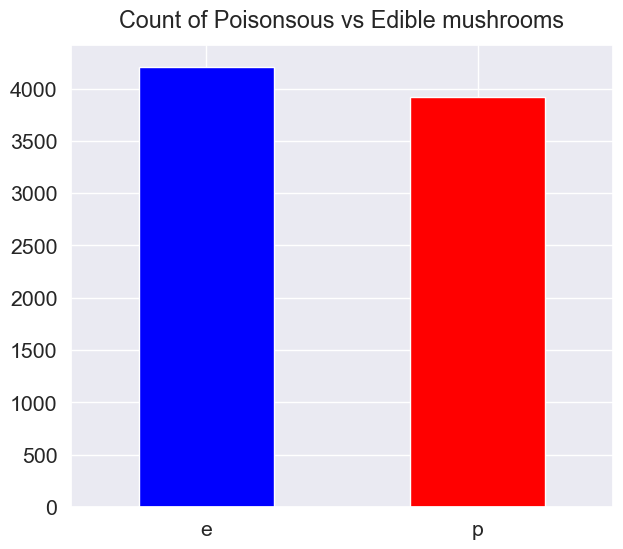

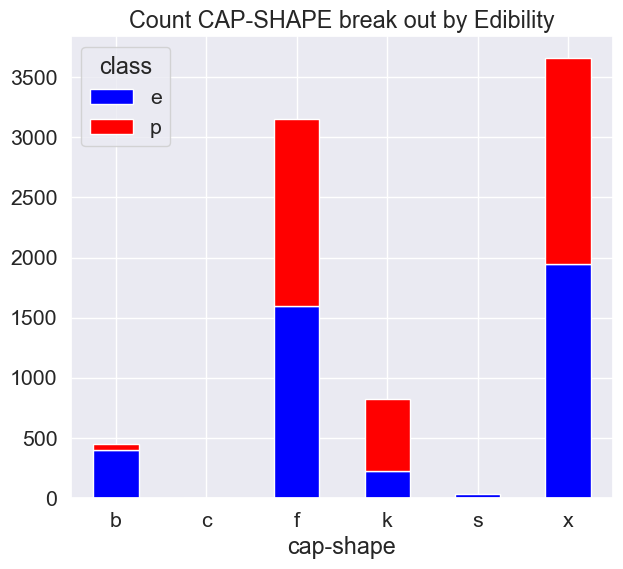

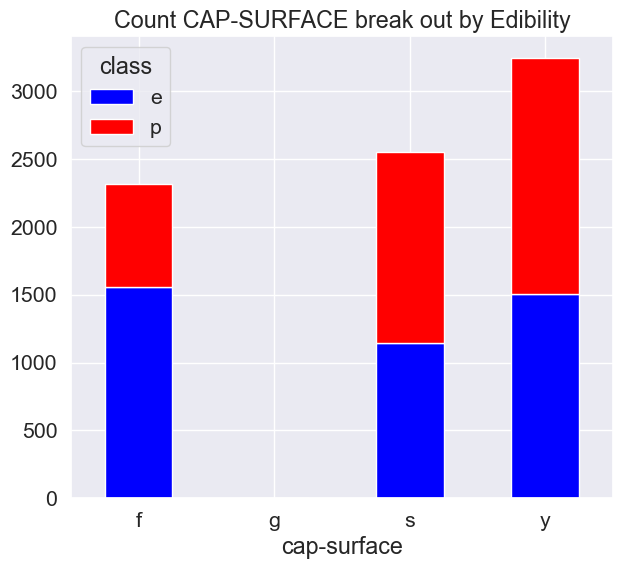

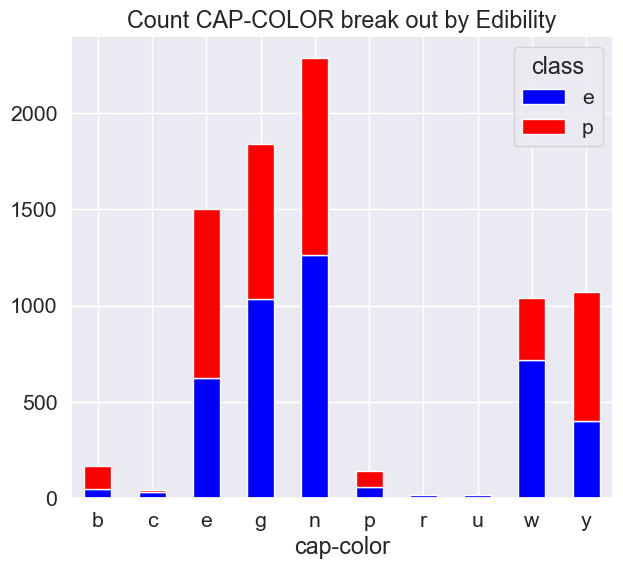

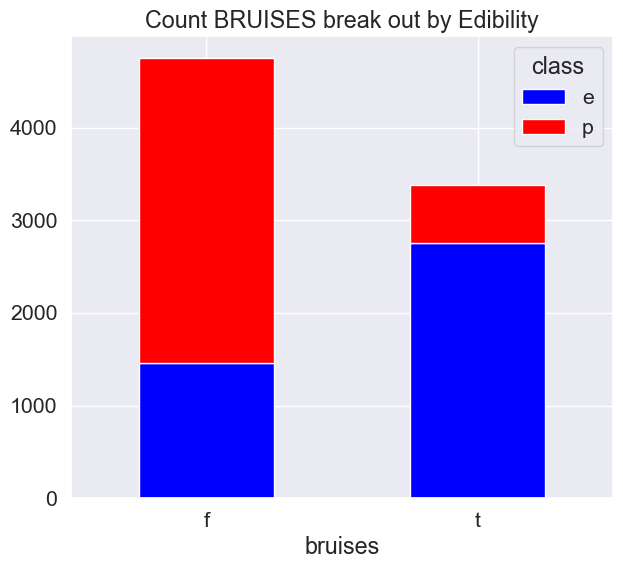

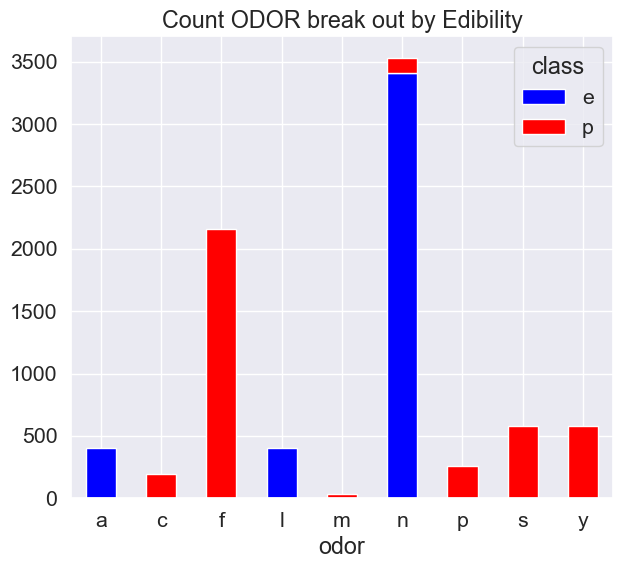

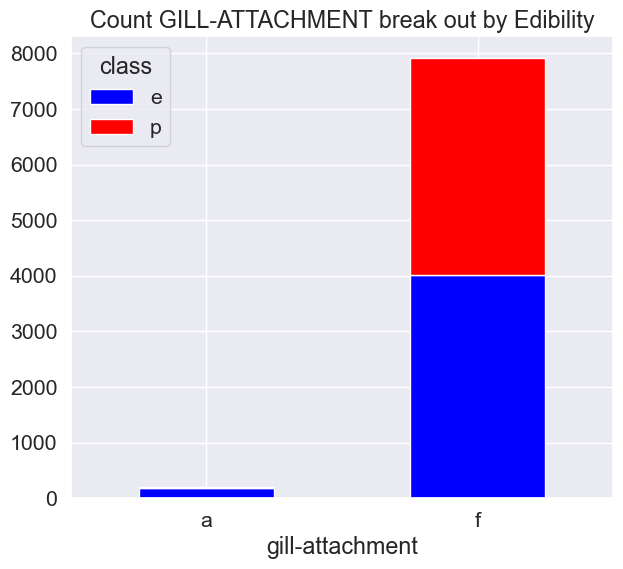

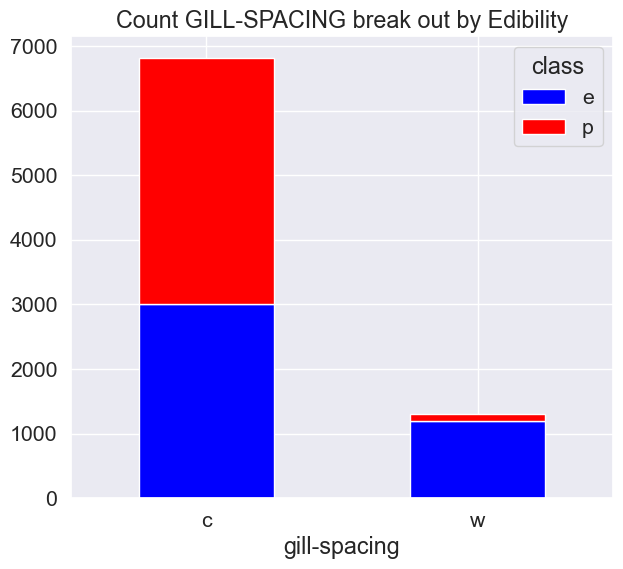

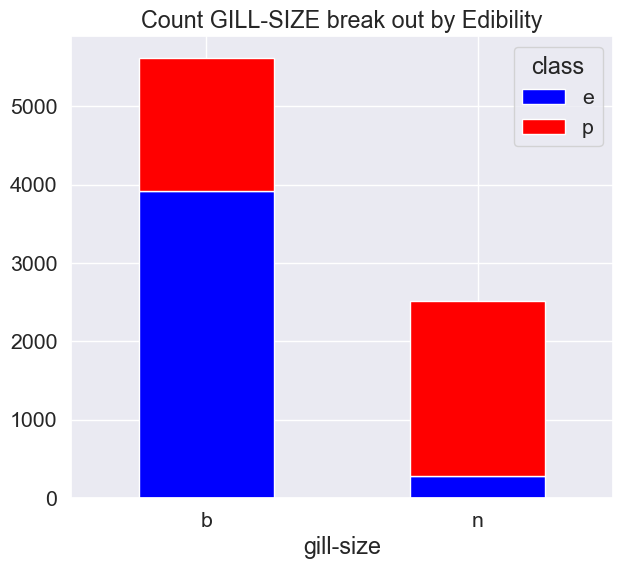

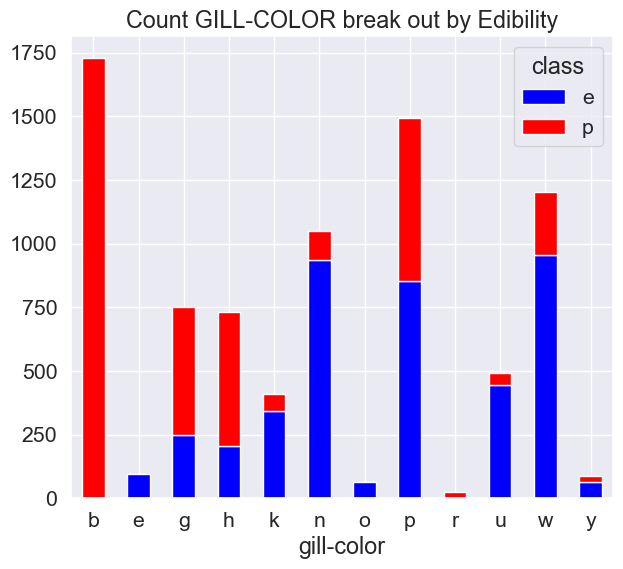

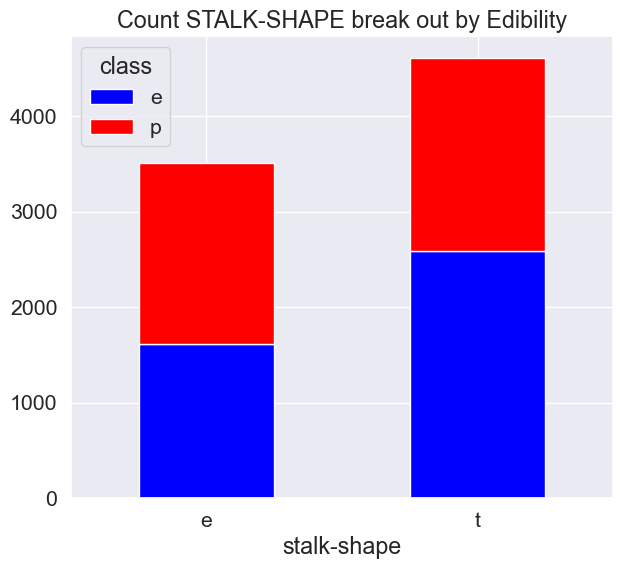

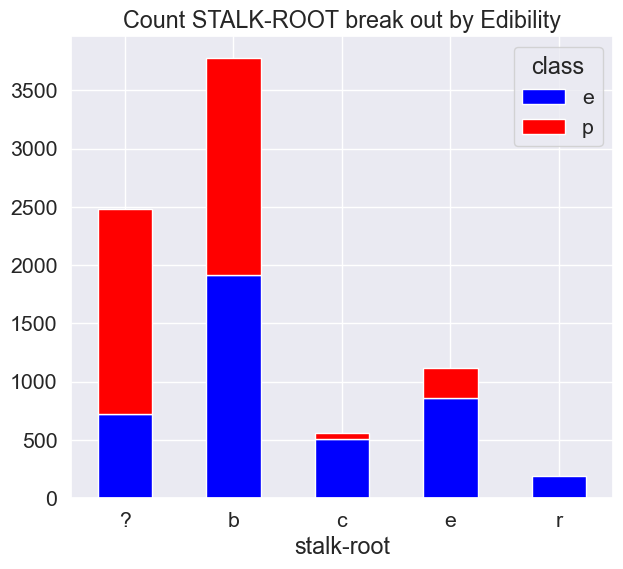

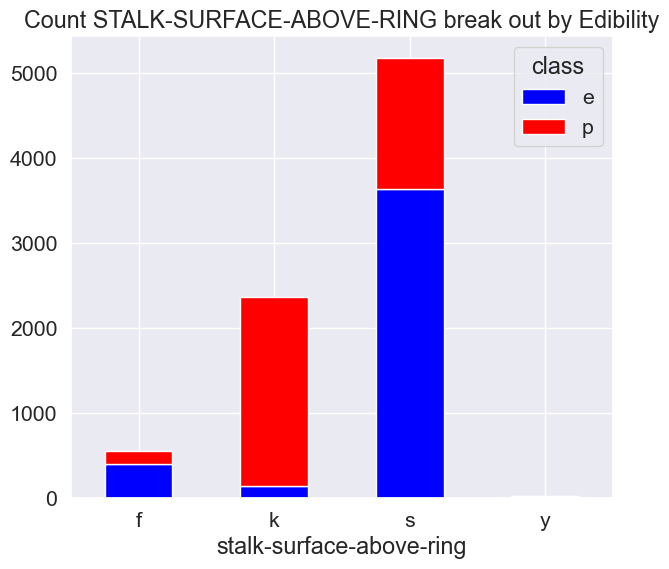

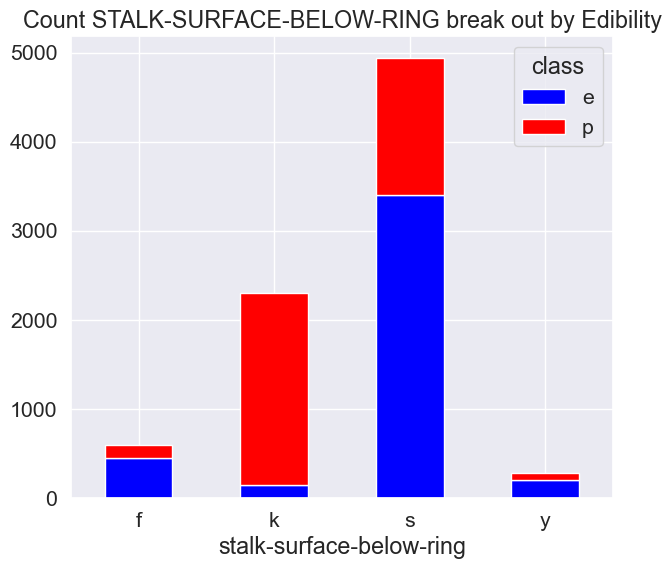

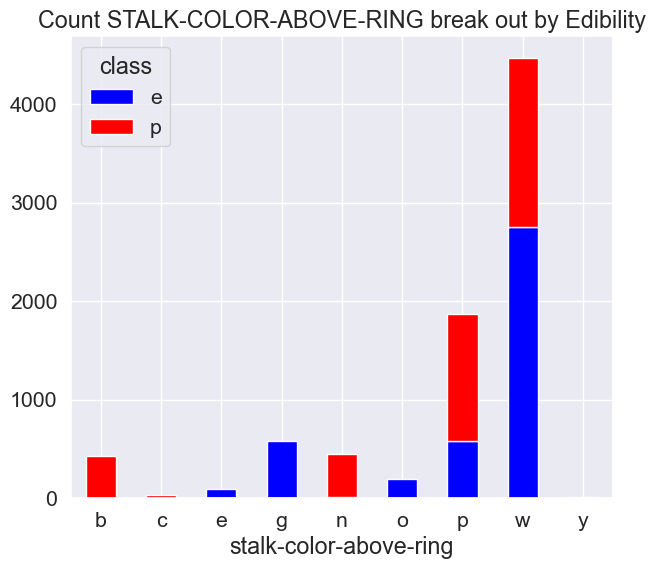

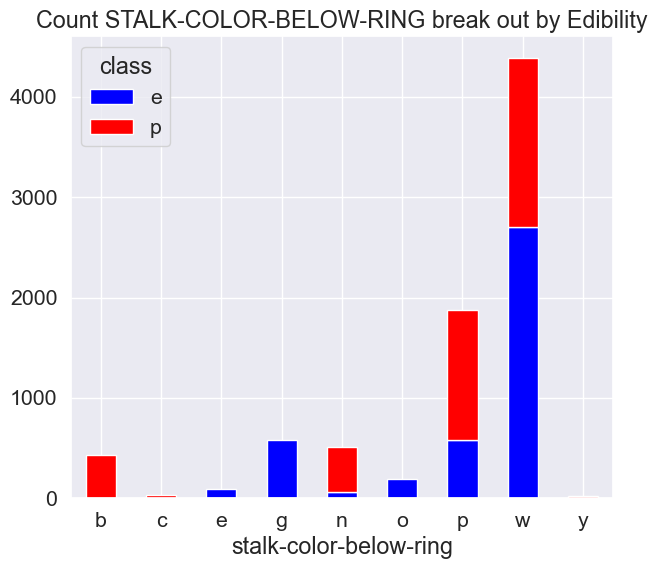

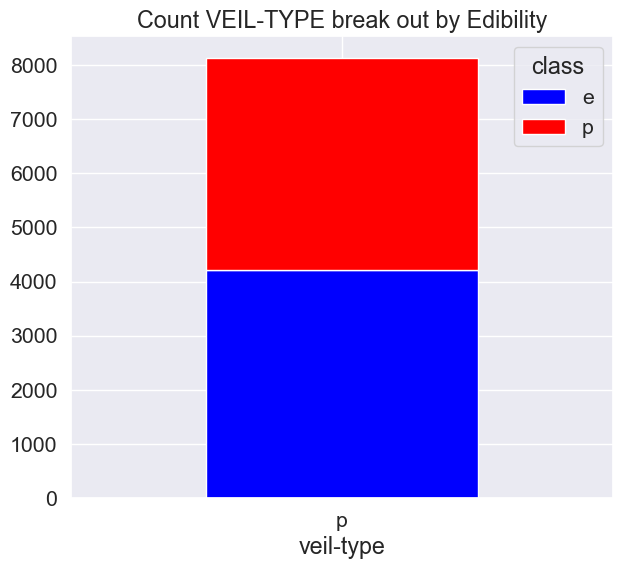

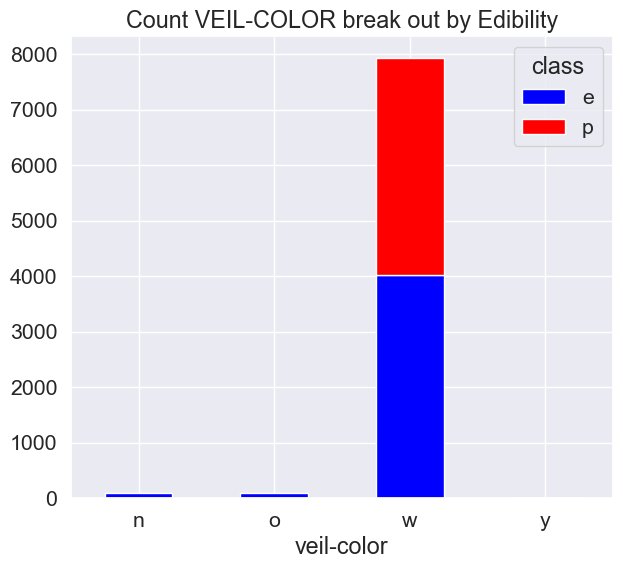

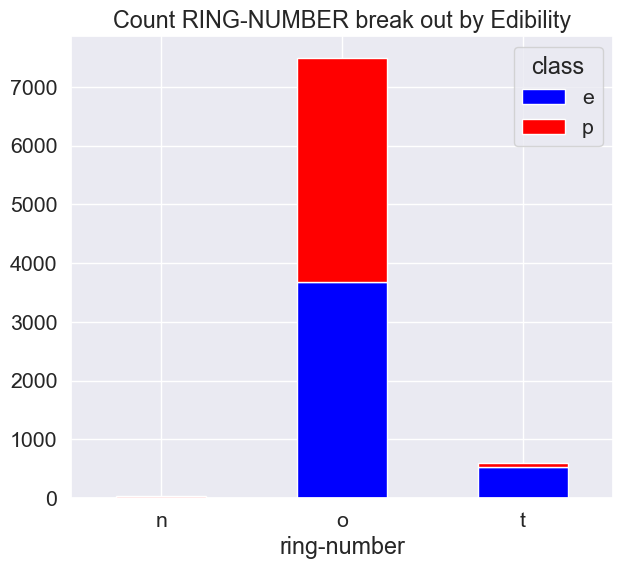

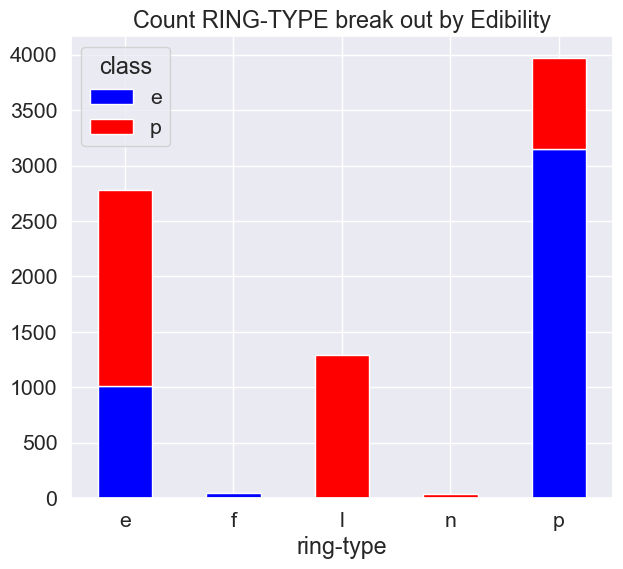

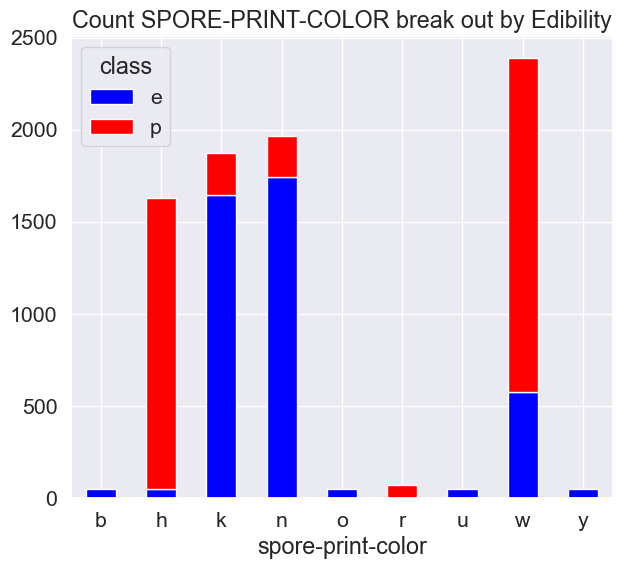

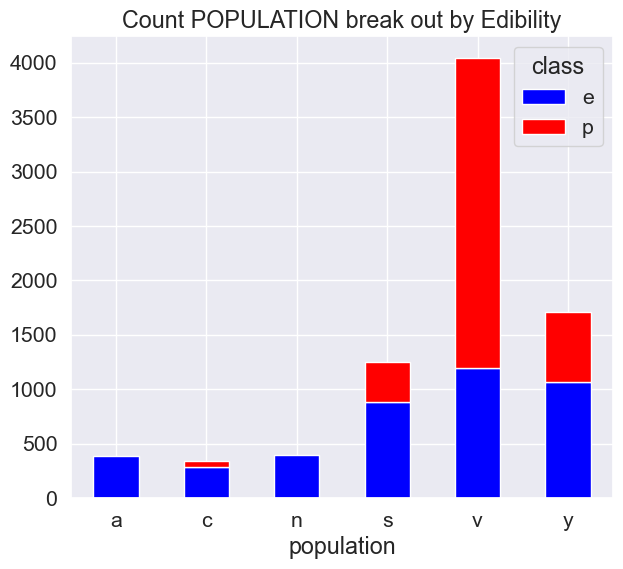

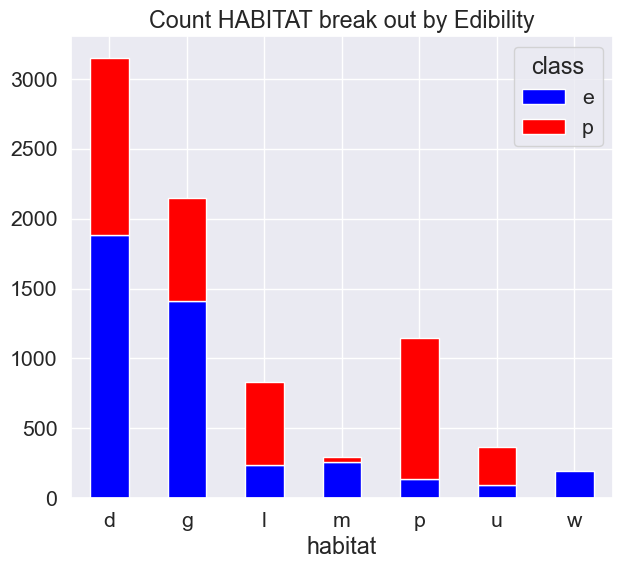

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64


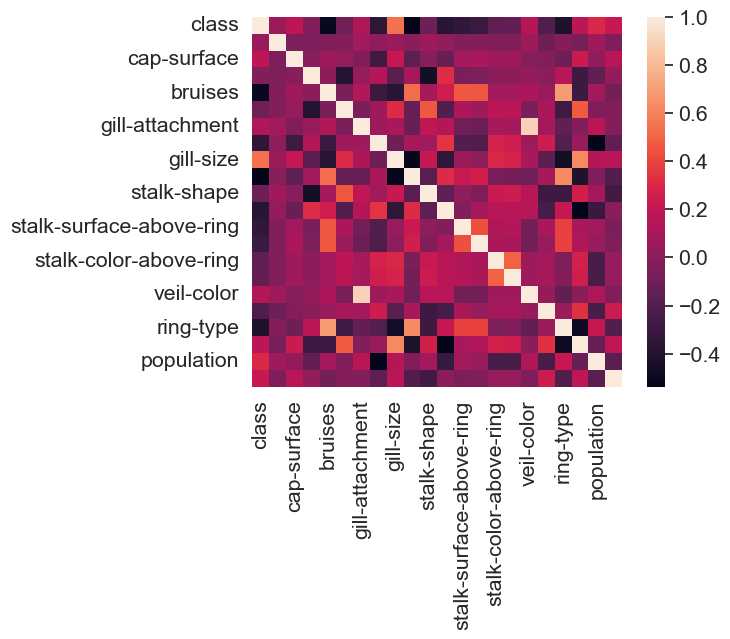

In [4]:
data = conduct_eda()

In [5]:
# split data into training and testing set
x = data.iloc[:, :-1]
y = data.iloc[:, 0]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.07, random_state=0)

# Train the decision tree
tree = DecisionTree()
tree.fit(x_train.values, y_train.values)

# Test the decision tree
y_pred = tree.predict(x_test.values)


# Test the decision tree
y_pred = tree.predict(x_test.values)


In [6]:
# checking the acuracy of the data
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 1.00


### Q.2 Implementing Decision Tree using Sklearn (10 points)

* You will implement the decision tree algorithm using the scikit-learn library.
* You will write a program that trains and tests a decision tree model on the mushroom dataset.
* Your implementation should include the following steps:
1. Load the mushroom dataset
2. Split the dataset into training and testing sets
3. Train a decision tree model on the training set
4. Test the model on the testing set and calculate the accuracy

In [7]:
# already load the mushroom data set through calling conducting EDA on the top (data = conduct_eda())
# Hence we will just used that to split the data here

# split data into training and testing set
x = data.iloc[:, :-1]
y = data.iloc[:, 0]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.07, random_state=0)

In [8]:
# Train a decision tree
tree_clf = DecisionTreeClassifier(criterion='entropy')
tree_clf.fit(x_train, y_train)


DecisionTreeClassifier(criterion='entropy')

In [9]:
# Test the model on the testing set and calculate the accuracy
y_pred = tree_clf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


### Q.3 Comparison between the results from Scratch and Sklearn  (5 points)

* You will compare the results obtained from your implementation from scratch with the results obtained from the scikit-learn library.

The results obtain by my implementation and scikit-learn are the same. Both results are at  1.00 or 100% accuracy.

### Q3. Neural Networks (25 Points)

1. **Forward Propagation** :  Calculate the value of L (7 points) . Use the weights and the input values to calculate the value of L using forward propagation.

2. **Backward Propagation**: Compute the derivatives (18 points). Use backward propagation to find the derivatives of the following variables with respect to each input and weight: (A1,A2,B1,B2,C1,C2,D). Use the chain rule to find the derivatives of each variable with respect to the inputs and weights.






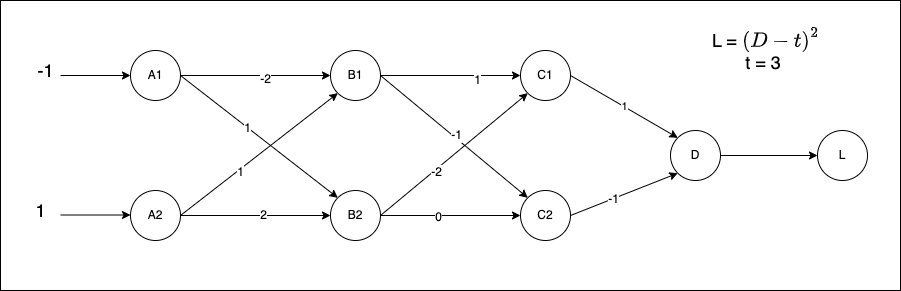